### Prerequisites

In [1]:
import random
import pandas as pd
import seaborn as sns

from base import *

### Server

In [2]:
class Server:
    def __init__(self) -> None:
        self.isCurrentlyUtilized: bool = False
        self.totalUtilizationTime: float = 0

### Customer

In [3]:
class Customer:
    def __init__(self) -> None:
        self.serviceTime: float
        self.departure: float
        self.arrival: float

    @property
    def totalTime(self) -> float:
        return self.departure - self.arrival

    @property
    def waitingTime(self) -> float:
        return self.totalTime - self.serviceTime

### Server Selection Strategy

In [4]:
class ServerSelectionStrategy:
    @staticmethod
    def firstAvailable(servers: Dict[int, Server]) -> int:
        serverId: int = -1
        serversList = list(servers.items())

        for id, server in serversList:
            if not server.isCurrentlyUtilized:
                serverId = id

        return serverId

    @staticmethod
    def random(servers: Dict[int, Server]) -> int:
        serverId: int = -1
        serversList = list(servers.items())

        random.shuffle(serversList)

        for id, server in serversList:
            if not server.isCurrentlyUtilized:
                serverId = id

        return serverId

### General Form of the Problem: Single Queue Multi-Server

In [5]:
class SingleQueueMultiServerController(SimController):
    def __init__(
        self,
        initialEvent: SimEvent,
        stop: float,
        numberOfServers: int,
        serverUtilizationStrategy: Callable[[Dict[int, Server]], int],
    ) -> None:
        assert numberOfServers > 0, "Non-positive number of servers"

        super().__init__(initialEvent, stop)

        self.history: List[Customer] = []
        self.queue: List[Customer] = []

        self.servers: Dict[int, Server] = {
            i: Server() for i in range(1, numberOfServers + 1)
        }

        self.serverUtilizationStrategy = serverUtilizationStrategy

    def simulate(self) -> Dict[str, float]:
        super().simulate()

        aup = sum(
            server.totalUtilizationTime / self.clock for server in self.servers.values()
        ) / len(self.servers)

        awtp = sum(
            customer.waitingTime / customer.totalTime for customer in self.history
        ) / len(self.history)

        return {"AUTP": aup, "AWTP": awtp, "ASTP": 1 - awtp}

### Special Case: Able & Baker

In [6]:
class AbleBakerController(SingleQueueMultiServerController):
    def __init__(
        self,
        initialEvent: SimEvent,
        stop: float,
        serverUtilizationStrategy: Callable[[Dict[int, Server]], int],
    ) -> None:
        super().__init__(
            initialEvent,
            stop,
            numberOfServers=2,
            serverUtilizationStrategy=serverUtilizationStrategy,
        )

    def simulate(self) -> Dict[str, float]:
        super().simulate()

        positiveWaitingTimes = list(
            filter(
                lambda waitingTime: waitingTime > 0,
                map(lambda customer: customer.waitingTime, self.history),
            )
        )

        return {
            "AWT": sum(positiveWaitingTimes) / len(positiveWaitingTimes),
            "WCP": len(positiveWaitingTimes) / len(self.history),
        } | {
            f"UTP_{id}": server.totalUtilizationTime / self.clock
            for id, server in self.servers.items()
        }

### Departure Event

In [7]:
DEPARTURE_EVENT_INTERVAL: Callable[[], float] = None


class DepartureEvent(SimEvent[AbleBakerController]):
    def __init__(self, customer: Customer, serverId: int) -> None:
        super().__init__(DEPARTURE_EVENT_INTERVAL())

        assert serverId >= 1

        self.customer = customer
        self.serverId = serverId

    def trigger(self) -> None:
        self.customer.serviceTime = self.interval
        self.customer.departure = self.due

        self.controller.history.append(self.customer)

        self.controller.servers[self.serverId].totalUtilizationTime += self.interval

        if self.controller.queue:
            customer = self.controller.queue.pop(0)

            self.controller.dispatchEvent(DepartureEvent(customer, self.serverId))
        else:
            self.controller.servers[self.serverId].isCurrentlyUtilized = False

### Arrival Event

In [8]:
ARRIVAL_EVENT_INTERVAL: Callable[[], float] = None


class ArrivalEvent(SimEvent[AbleBakerController]):
    def __init__(self, initial: bool = False) -> None:
        super().__init__(0 if initial else ARRIVAL_EVENT_INTERVAL())

        self.customer = Customer()

    def trigger(self) -> None:
        self.customer.arrival = self.due

        self.controller.dispatchEvent(ArrivalEvent())

        serverId = self.controller.serverUtilizationStrategy(self.controller.servers)

        if serverId == -1:
            self.controller.queue.append(self.customer)
        else:
            self.controller.servers[serverId].isCurrentlyUtilized = True
            self.controller.dispatchEvent(DepartureEvent(self.customer, serverId))

### Problem 1

#### Selecting Servers Randomly

In [9]:
ARRIVAL_EVENT_INTERVAL = lambda: DistributionFunction.uniform(3, 6)
DEPARTURE_EVENT_INTERVAL = lambda: DistributionFunction.uniform(9, 12)


allResults = []

for i in range(1000):
    results = AbleBakerController(
        initialEvent=ArrivalEvent(initial=True),
        stop=9 * 60,
        serverUtilizationStrategy=ServerSelectionStrategy.firstAvailable,
    ).simulate()

    allResults.append(results)

pd.DataFrame(allResults).mean(axis=0)

AWT      38.289603
WCP       0.977032
UTP_1     0.984556
UTP_2     0.993068
dtype: float64

#### Selecting the First Available Server

In [10]:
ARRIVAL_EVENT_INTERVAL = lambda: DistributionFunction.uniform(3, 6)
DEPARTURE_EVENT_INTERVAL = lambda: DistributionFunction.uniform(9, 12)

allResults = []

for i in range(1000):
    results = AbleBakerController(
        initialEvent=ArrivalEvent(initial=True),
        stop=9 * 60,
        serverUtilizationStrategy=ServerSelectionStrategy.random,
    ).simulate()

    allResults.append(results)

pd.DataFrame(allResults).mean(axis=0)

AWT      38.362878
WCP       0.977638
UTP_1     0.988914
UTP_2     0.988742
dtype: float64

### Problem 2

#### Solution

In [11]:
ARRIVAL_EVENT_INTERVAL = lambda: DistributionFunction.uniform(0, 4)
DEPARTURE_EVENT_INTERVAL = lambda: DistributionFunction.uniform(6, 10)

allResults = {}

for numberOfServers in range(1, 11):
    iterResults = []

    for i in range(1000):
        results = SingleQueueMultiServerController(
            initialEvent=ArrivalEvent(initial=True),
            stop=8 * 60,
            numberOfServers=numberOfServers,
            serverUtilizationStrategy=ServerSelectionStrategy.random,
        ).simulate()

        iterResults.append(results)

    allResults[numberOfServers] = pd.DataFrame(iterResults).mean(axis=0)

df = pd.DataFrame(allResults).T

df["Score"] = 2 * df["AUTP"] * df["ASTP"] / (df["AUTP"] + df["ASTP"])

df

,AUTP,AWTP,ASTP,Score
1,0.993869,0.904710,0.095290,0.173906
2,0.991482,0.874826,0.125174,0.222284
3,0.988457,0.800267,0.199733,0.332317
4,0.960138,0.399333,0.600667,0.739007
5,0.788233,0.057165,0.942835,0.858630
6,0.657605,0.012788,0.987212,0.789383
7,0.563745,0.002873,0.997127,0.720271
8,0.494336,0.000713,0.999287,0.661457
9,0.438731,0.000119,0.999881,0.609864
10,0.395381,0.000017,0.999983,0.566697


##### Results

<Axes: >

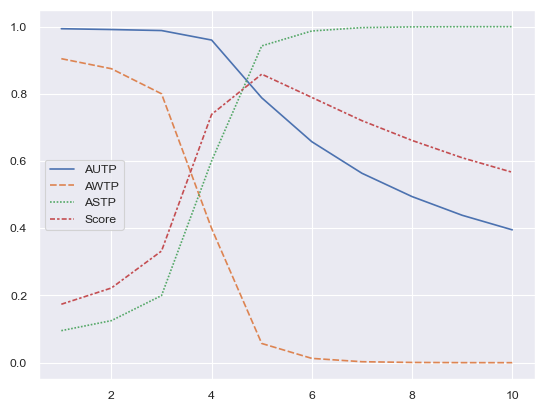

In [14]:
sns.set_theme("paper")
sns.lineplot(df)